# Comparative Performance Analysis of Language Models on Sentiment Analysis: A Case Study with Rotten Tomatoes Movie Reviews

In [1]:
# Data process
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Softmax
from scipy.special import softmax

# HuggingFace
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BertTokenizer,
    BertModel,
    BertForSequenceClassification,
    DistilBertTokenizer,
    DistilBertModel,
    DistilBertForSequenceClassification,
    RobertaTokenizer,
    RobertaModel
)

# WordCloud
from wordcloud import WordCloud

# NLTK
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# PyTorch
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay
)

# TQDM
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Load Dataset

In [2]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",split=["train", "validation", "test"])
train_data, validation_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 8530
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }))

In [3]:
# Examples
print(train_data[0])
print(train_data[100])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
{'text': 'chicago is sophisticated , brash , sardonic , completely joyful in its execution .', 'label': 1}


In [4]:
# Converting data into pandas df form
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Distribution between pos/neg reviews')

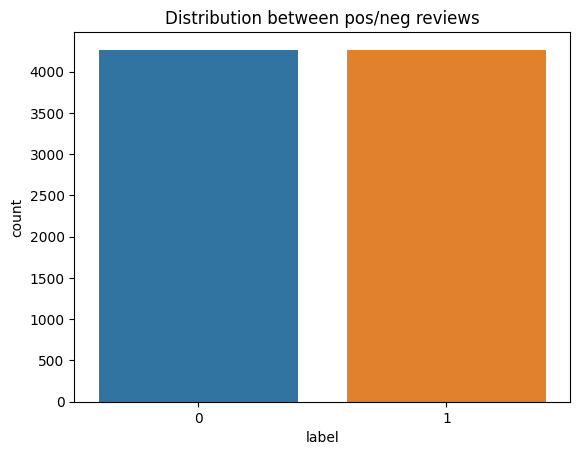

In [6]:
# Distribution between positive and negative reviews
sns.countplot(data=train_df, x='label')
plt.title("Distribution between pos/neg reviews")

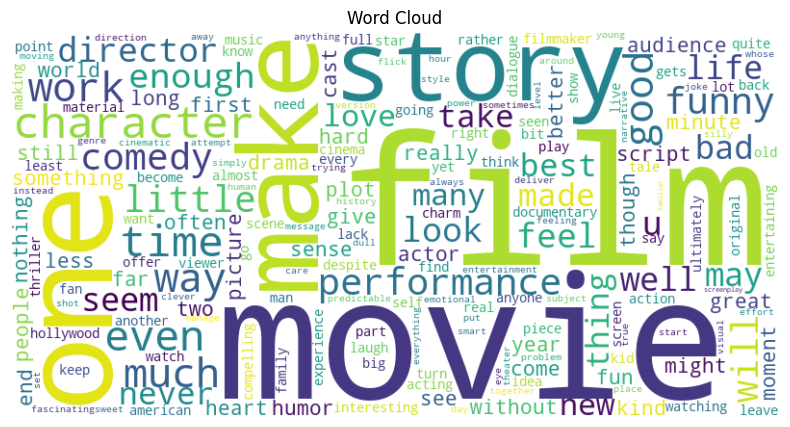

In [7]:
# Combine all text from the single column into one string
text = " ".join(train_df['text'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

## NLTK Baseline

In [8]:
# Function to run NLTK's Vader
def vaders_baseline(df):
    # Download VADER lexicon
    nltk.download('vader_lexicon')
    
    # Create instance of Sentiment Intensity Analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Applying polarity scores to the entire train_df
    results = {}
    for index, row in tqdm(train_df.iterrows(), total=len(df)):
        text = row['text']
        results[index] = sia.polarity_scores(text)
    
    # Convert into pandas dataframe
    vaders = pd.DataFrame(results).T
    
    # Assigning predicted labels based on VADERS results
    vader_labels = {}
    for index, row in tqdm(vaders.iterrows(), total=len(vaders)):
        label = 1 if row['compound'] >= 0 else 0
        vader_labels[index] = label
    
    # Make predictions into a column
    vaders['predicted_label'] = pd.Series(vader_labels)
    vaders['label'] = train_df['label']
    
    # Assign lables
    y_true = vaders['label']
    y_pred = vaders['predicted_label']
    
    # Classification metrics
    accuracy = round(accuracy_score(y_true, y_pred), 4)
    precision = round(precision_score(y_true, y_pred), 4)
    recall = round(recall_score(y_true, y_pred), 4)
    f1 = round(f1_score(y_true, y_pred), 4)
    roc_auc = round(roc_auc_score(y_true, y_pred), 4)
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    # Print results
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC Score: {roc_auc}")
    print("Classification Report:\n", report)
    
    # Confusion matrix
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|██████████| 8530/8530 [00:00<00:00, 36839.99it/s]


Accuracy: 0.61
Precision: 0.5771
Recall: 0.823
F1 Score: 0.6785
ROC-AUC Score: 0.61
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.40      0.50      4265
           1       0.58      0.82      0.68      4265

    accuracy                           0.61      8530
   macro avg       0.63      0.61      0.59      8530
weighted avg       0.63      0.61      0.59      8530



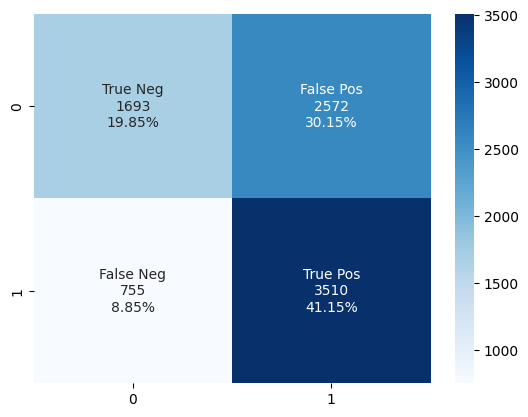

In [9]:
# Running vaders
train_df = pd.DataFrame(train_data)
vaders_baseline(train_df)

## Pipeline for Pre-Trained Models

In [10]:
# Tokenize texts
def tokenize_texts(text, tokenizer, model):
    encoded_text = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_text)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    return scores

# Polarity scores for pre-tuned Bert-based models
def polarity_score(text, tokenizer, model):
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[0],
        'pos_score' : scores[1]
    }
    return scores_dict

# Polarity scores for fine-tuned RoBERTa
def roberta_tuned_polarity_score(text, tokenizer, model):
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[0] + (scores[1]/2),
        'pos_score' : scores[2] + (scores[1]/2)
    }
    return scores_dict

# Polarity scores for fine-tuned DistilBERT
def distilbert_tuned_polarity_score(text, tokenizer, model):
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[2] + (scores[1]/2),
        'pos_score' : scores[0] + (scores[1]/2)
    }
    return scores_dict

# Polarity scores for fine-tuned BERT
def bert_tuned_polarity_score(text, tokenizer, model):
    scores = tokenize_texts(text, tokenizer, model)
    scores_dict = {
        'neg_score' : scores[0] + scores[1] + (scores[2]/2),
        'pos_score' : scores[3] + scores[4] + (scores[2]/2)
    }
    return scores_dict

In [11]:
def pre_tuned_classifier(model, tokenizer, dataset, name):

    # Running the model on the entire train_df dataset
    res = {}
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        try:
            text = row['text']
            if name == 'roberta_tuned':
                res[index] = roberta_tuned_polarity_score(text, tokenizer, model)
            elif name == 'distilbert_tuned':
                res[index] = distilbert_tuned_polarity_score(text, tokenizer, model)
            elif name == 'bert_tuned':
                res[index] = bert_tuned_polarity_score(text, tokenizer, model)
            else:
                res[index] = polarity_score(text, tokenizer, model)
        except RuntimeError:
            print(f'Broke for id {index}')

    # Displaying the result in a dataframe format
    results = pd.DataFrame(res).T

    # Convert model outputs into binary classification
    labels = {}
    num_of_cols = len(results.columns)
    for index,row in results.iterrows():
        label = 1 if row['pos_score'] >= row['neg_score'] else 0
        labels[index] = label

    # Add predicted labels columns into results
    results['predicted_labels'] = pd.Series(labels)

    return results

In [12]:
# def model_setup(model):
#     tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")  #, return_tensors='pt',
#                                                #truncation=True, max_length=256, padding=True)
#     roberta_model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base")
#     roberta_model = roberta_model.to(device)
    
#     if model == 'cardiffnlp/twitter-roberta-base-sentiment':
#         tag = 'roberta_tuned'
#     elif model == 'lxyuan/distilbert-base-multilingual-cased-sentiments-student':
#         tag = 'distilbert_tuned'
#     elif model == 'nlptown/bert-base-multilingual-uncased-sentiment':
#         tag = 'bert_tuned'
#     else:
#         tag = 'pre-tuned'
        
#     return model, tokenizer, tag

In [13]:
# roberta_model, tokenizer, tag = model_setup("FacebookAI/roberta-base")
# print(tag)
# roberta_results = pre_tuned_classifier(roberta_model, tokenizer, test_df, tag)

In [14]:
# Roberta Pre-Tuned
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base", return_tensors='pt',
                                          truncation=True, max_length=256, padding=True)
roberta_model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base")
roberta_model = roberta_model.to(device)
roberta_results = pre_tuned_classifier(roberta_model, tokenizer, test_df, 'roberta')

# Roberta Fine-Tuned on Twitter
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", return_tensors='pt',
                                          truncation=True, max_length=256, padding=True)
roberta_tuned_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta_tuned_model = roberta_tuned_model.to(device)
roberta_tuned_results = pre_tuned_classifier(roberta_tuned_model, tokenizer, test_df, 'roberta_tuned')

# DistilBert Pre-Tuned
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_tensors='pt',
                                          truncation=True, max_length=256, padding=True)
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
distilbert_model = distilbert_model.to(device)
distilbert_results = pre_tuned_classifier(distilbert_model, tokenizer, test_df, 'distilbert')

# DistilBert Fine-Tuned
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", return_tensors='pt',
                                          truncation=True, max_length=256, padding=True)
distilbert_tuned_model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
distilbert_tuned_model = distilbert_tuned_model.to(device)
distilbert_tuned_results = pre_tuned_classifier(distilbert_tuned_model, tokenizer, test_df, 'distilbert_tuned')

# Bert Pre-Tuned
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", return_tensors='pt',
                                          truncation=True, max_length=256, padding=True)
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
bert_model = bert_model.to(device)
bert_results = pre_tuned_classifier(bert_model, tokenizer, test_df, 'bert')

# Bert Fine-Tuned
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", return_tensors='pt',
                                          truncation=True, max_length=256, padding=True)
bert_tuned_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
bert_tuned_model = bert_tuned_model.to(device)
bert_tuned_results = pre_tuned_classifier(bert_tuned_model, tokenizer, test_df, 'bert_tuned')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1066/1066 [00:10<00:00, 101.55it/s]
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. Th

In [15]:
# Assign lables
y_true = test_df['label']
roberta_predicted = roberta_results['predicted_labels']
roberta_tuned_predicted = roberta_tuned_results['predicted_labels']
distilbert_predicted = distilbert_results['predicted_labels']
distilbert_tuned_predicted = distilbert_tuned_results['predicted_labels']
bert_predicted = bert_results['predicted_labels']
bert_tuned_predicted = bert_tuned_results['predicted_labels']

# Accuracy
roberta_acc = round(accuracy_score(y_true, roberta_predicted), 4)
roberta_tuned_acc = round(accuracy_score(y_true, roberta_tuned_predicted), 4)
distilbert_acc = round(accuracy_score(y_true, distilbert_predicted), 4)
distilbert_tuned_acc = round(accuracy_score(y_true, distilbert_tuned_predicted), 4)
bert_acc = round(accuracy_score(y_true, bert_predicted), 4)
bert_tuned_acc = round(accuracy_score(y_true, bert_tuned_predicted), 4)

# Precision
roberta_precision = round(precision_score(y_true, roberta_predicted), 4)
roberta_tuned_precision = round(precision_score(y_true, roberta_tuned_predicted), 4)
distilbert_precision = round(precision_score(y_true, distilbert_predicted), 4)
distilbert_tuned_precision = round(precision_score(y_true, distilbert_tuned_predicted), 4)
bert_precision = round(precision_score(y_true, bert_predicted), 4)
bert_tuned_precision = round(precision_score(y_true, bert_tuned_predicted), 4)

# Recall
roberta_recall = round(recall_score(y_true, roberta_predicted), 4)
roberta_tuned_recall = round(recall_score(y_true, roberta_tuned_predicted), 4)
distilbert_recall = round(recall_score(y_true, distilbert_predicted), 4)
distilbert_tuned_recall = round(recall_score(y_true, distilbert_tuned_predicted), 4)
bert_recall = round(recall_score(y_true, bert_predicted), 4)
bert_tuned_recall = round(recall_score(y_true, bert_tuned_predicted), 4)

# F1-Score
roberta_f1_score = round(f1_score(y_true, roberta_predicted), 4)
roberta_tuned_f1_score = round(f1_score(y_true, roberta_tuned_predicted), 4)
distilbert_f1_score = round(f1_score(y_true, distilbert_predicted), 4)
distilbert_tuned_f1_score = round(f1_score(y_true, distilbert_tuned_predicted), 4)
bert_f1_score = round(f1_score(y_true, bert_predicted), 4)
bert_tuned_f1_score = round(f1_score(y_true, bert_tuned_predicted), 4)

# ROC-AUC
roberta_roc_auc = round(roc_auc_score(y_true, roberta_predicted), 4)
roberta_tuned_roc_auc = round(roc_auc_score(y_true, roberta_tuned_predicted), 4)
distilbert_roc_auc = round(roc_auc_score(y_true, distilbert_predicted), 4)
distilbert_tuned_roc_auc = round(roc_auc_score(y_true, distilbert_tuned_predicted), 4)
bert_roc_auc = round(roc_auc_score(y_true, bert_predicted), 4)
bert_tuned_roc_auc = round(roc_auc_score(y_true, bert_tuned_predicted), 4)

# Display results in df
pre_tuned_results = pd.DataFrame({
    "model": ['RoBERTa', 'Fine-tuned RoBERTa',
              'DistilBERT', 'Fine-tuned DistilBERT',
              'BERT', 'Fine-tuned BERT'],
    "accuracy": [roberta_acc, roberta_tuned_acc,
                 distilbert_acc, distilbert_tuned_acc,
                 bert_acc, bert_tuned_acc],
    "precision": [roberta_precision, roberta_tuned_precision,
                  distilbert_precision, distilbert_tuned_precision,
                  bert_precision, bert_tuned_precision],
    "recall": [roberta_recall, roberta_tuned_recall,
               distilbert_recall, distilbert_tuned_recall,
               bert_recall, bert_tuned_recall],
    "f1 score": [roberta_f1_score, roberta_tuned_f1_score,
                 distilbert_f1_score, distilbert_tuned_f1_score,
                 bert_f1_score, bert_tuned_f1_score],
    "roc-auc score": [roberta_roc_auc, roberta_tuned_roc_auc,
                      distilbert_roc_auc, distilbert_tuned_roc_auc,
                      bert_roc_auc, bert_tuned_roc_auc]
})
pre_tuned_results

,model,accuracy,precision,recall,f1 score,roc-auc score
0,RoBERTa,0.4944,0.4970,0.9306,0.6479,0.4944
1,Fine-tuned RoBERTa,0.7871,0.8148,0.7430,0.7772,0.7871
2,DistilBERT,0.4653,0.4757,0.6792,0.5595,0.4653
3,Fine-tuned DistilBERT,0.6445,0.6851,0.5347,0.6006,0.6445
4,BERT,0.4765,0.4194,0.1220,0.1890,0.4765
5,Fine-tuned BERT,0.7749,0.7504,0.8236,0.7853,0.7749


## Prepare Data for LLMs

In [16]:
# Create Dataset class
class SentimentDataset(Dataset):
    # Constructor method
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    # Length of dataset
    def __len__(self):
        return len(self.texts)

    # Get item of dataset
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Tokenize text
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            return_token_type_ids=False,  # Set to False because we're only doing sentiment analysis
            padding='max_length',  # Pad to max_length for consistent token length
            truncation=True,  # Truncate to max_length for consisten token length
            return_tensors="pt"  # Return tensors in PyTorch format
        )
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [17]:
def data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size):
    
    # Assign texts and labels
    train_texts = train_df['text']
    train_labels = train_df['label']
    val_texts = val_df['text']
    val_labels = val_df['label']
    test_texts = test_df['text']
    test_labels = test_df['label']
    
    # Datasets
    dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_length=max_length)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_length=max_length)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_length=max_length)
    
    # DataLoader
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Create Sentiment Classifier

In [18]:
# Sentimet Classifier class
class SentimentClassifier(nn.Module):
    # Constructor method
    def __init__(self, n_classes, model):
        super(SentimentClassifier, self).__init__()  # Inherit parent class
        self.model = model
        self.dropout = nn.Dropout(0.3)  # Dropout to reduce overfitting
        self.fc = nn.Linear(self.model.config.hidden_size, n_classes)  # Fully-connected layer to convert output into binary

    # Feed forward method
    def forward(self, input_ids, attention_mask):

        # Use second last layer of pooling output
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        second_to_last_layer = hidden_states[-2]  # Extract second-to-last layer
        cls_token = second_to_last_layer[:, 0, :]  # Pool the CLS token
        output = self.dropout(cls_token)

        return self.fc(output)

## Train and Validate Model

In [19]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, history):
    # Training Phase
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    train_batches = len(train_loader)

    # Live tracking using tqdm
    pbar = tqdm(train_loader, desc="Training", leave=False)

    # Train data in batches
    for batch_idx, batch in enumerate(pbar):

        # Move inputs and labels to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Reset gradients on each epoch
        optimizer.zero_grad()

        # Model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Keep track of training losses
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Model predictions using argmax
        preds = torch.argmax(outputs, dim=1)

        # Compute running accuracy
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        running_accuracy = train_correct / train_total
        running_loss = train_loss / (batch_idx + 1)

        # Update progress bar description
        pbar.set_description(f"Training: Loss {running_loss:.4f} | Acc {running_accuracy:.4f}")

        # Update gradients
        loss.backward()
        optimizer.step()

    # Epoch-level metrics
    epoch_train_loss = train_loss / train_batches
    epoch_train_accuracy = train_correct / train_total
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_accuracy)

    # Print epoch metrics
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

    return history

In [20]:
def evaluate_model(model, val_loader, loss_fn, device, history):
    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_batches = len(val_loader)

    # Run without updating gradients
    with torch.no_grad():

        # Evaluate model in batches
        for batch in tqdm(val_loader, desc="Validation", leave=False):

            # Move inputs to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Track validation losses
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Model predictions using argmax
            preds = torch.argmax(outputs, dim=1)
            
            # Calculate metrics
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Epoch-level metrics
    epoch_val_loss = val_loss / val_batches
    epoch_val_accuracy = val_correct / val_total
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_accuracy)

    # Print epoch metrics
    print(f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    return history

In [21]:
# Train and evaluate model per epoch
def train_and_evaluate_model(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, history):

    # Move model to GPU
    model.to(device)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        history = train_model(model, train_loader, val_loader, optimizer, loss_fn, device, history)
        history = evaluate_model(model, val_loader, loss_fn, device, history)

    return history

## Plot Metrics

In [22]:
# Plot metrics
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Display plot
    plt.show()

## Run Pipeline

In [23]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup
max_length = 256
batch_size = 64
num_of_epochs = 5

roberta_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
distilbert_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
bert_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Train Loss: 0.6845, Train Accuracy: 0.5913


Val Loss: 0.3816, Val Accuracy: 0.8452
Epoch 2/5


Train Loss: 0.3503, Train Accuracy: 0.8608


Val Loss: 0.3036, Val Accuracy: 0.8762
Epoch 3/5


Train Loss: 0.3073, Train Accuracy: 0.8751


Val Loss: 0.2894, Val Accuracy: 0.8846
Epoch 4/5


Train Loss: 0.2910, Train Accuracy: 0.8828


Val Loss: 0.3016, Val Accuracy: 0.8874
Epoch 5/5


Train Loss: 0.2939, Train Accuracy: 0.8842


Val Loss: 0.3132, Val Accuracy: 0.8724


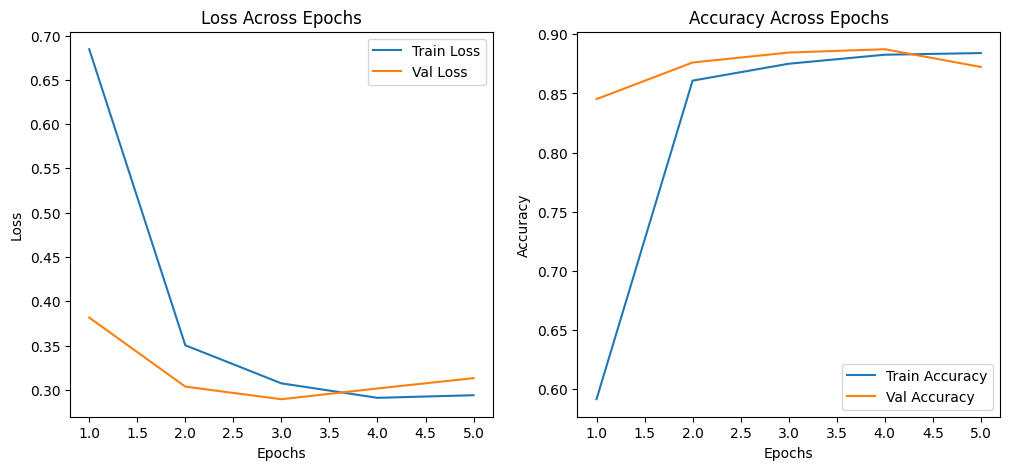

In [24]:
# Run Roberta
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
train_loader, val_loader, test_loader = data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size)

roberta_model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/roberta-base", output_hidden_states=True)
roberta_model = SentimentClassifier(n_classes=2, model=roberta_model)
roberta_model = roberta_model.to(device)

optimizer = torch.optim.Adam(roberta_model.parameters(), lr=2e-5, weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

roberta_history = train_and_evaluate_model(roberta_model, train_loader, val_loader,
                                           optimizer, loss_fn, num_of_epochs, device, roberta_history)

# Plot metrics
plot_metrics(roberta_history)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Train Loss: 0.6542, Train Accuracy: 0.6095


Val Loss: 0.5564, Val Accuracy: 0.7448
Epoch 2/5


Train Loss: 0.4850, Train Accuracy: 0.7707


Val Loss: 0.4389, Val Accuracy: 0.7927
Epoch 3/5


Train Loss: 0.4292, Train Accuracy: 0.8021


Val Loss: 0.4087, Val Accuracy: 0.8077
Epoch 4/5


Train Loss: 0.4138, Train Accuracy: 0.8093


Val Loss: 0.4042, Val Accuracy: 0.8208
Epoch 5/5


Train Loss: 0.3996, Train Accuracy: 0.8215


Val Loss: 0.4015, Val Accuracy: 0.8124


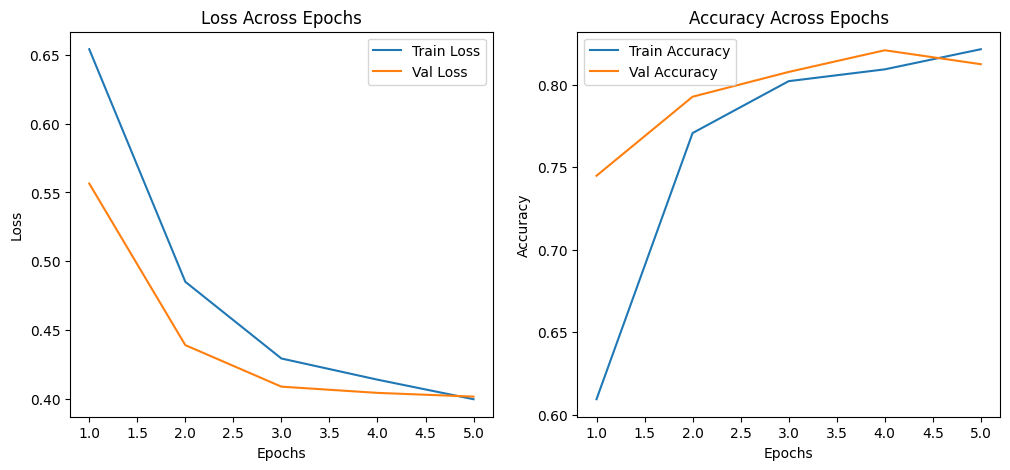

In [25]:
# Run DistilBert
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_loader, val_loader, test_loader = data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size)

distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
distilbert_model = SentimentClassifier(n_classes=2, model=distilbert_model)
distilbert_model = distilbert_model.to(device)

optimizer = torch.optim.Adam(distilbert_model.parameters(), lr=2e-5, weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

history = train_and_evaluate_model(distilbert_model, train_loader, val_loader,
                                   optimizer, loss_fn, num_of_epochs, device, distilbert_history)

# Plot metrics
plot_metrics(distilbert_history)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Train Loss: 0.6216, Train Accuracy: 0.6385


Val Loss: 0.3940, Val Accuracy: 0.8302
Epoch 2/5


Train Loss: 0.3948, Train Accuracy: 0.8265


Val Loss: 0.3447, Val Accuracy: 0.8499
Epoch 3/5


Train Loss: 0.3553, Train Accuracy: 0.8478


Val Loss: 0.3416, Val Accuracy: 0.8508
Epoch 4/5


Train Loss: 0.3560, Train Accuracy: 0.8424


Val Loss: 0.3508, Val Accuracy: 0.8349
Epoch 5/5


Train Loss: 0.3552, Train Accuracy: 0.8445


Val Loss: 0.3561, Val Accuracy: 0.8246


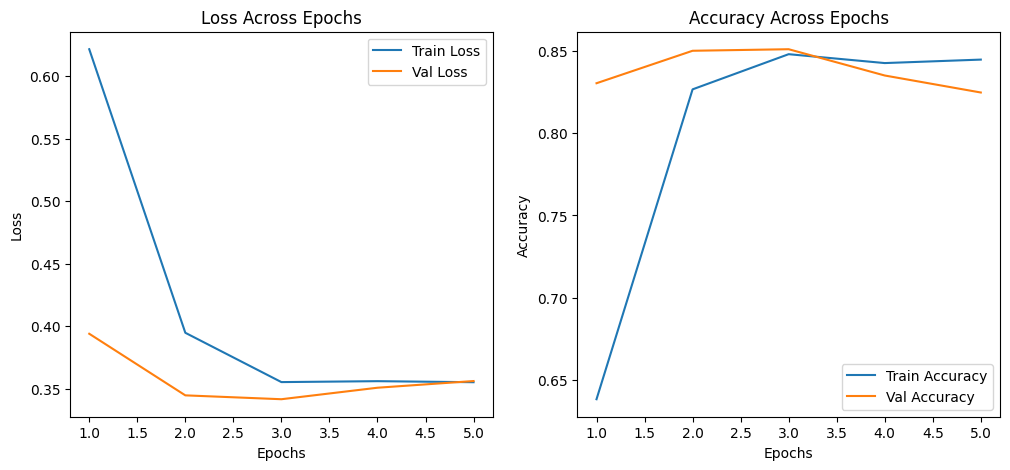

In [26]:
# Run Bert
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_loader, val_loader, test_loader = data_preparation(train_df, val_df, test_df, tokenizer, max_length, batch_size)

bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_model = SentimentClassifier(n_classes=2, model=bert_model)
bert_model = bert_model.to(device)

optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5, weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

history = train_and_evaluate_model(bert_model, train_loader, val_loader,
                                   optimizer, loss_fn, num_of_epochs, device, bert_history)

# Plot metrics
plot_metrics(bert_history)

# Testing

In [27]:
# Test function
def test_model(model, dataloader):

    # Set model to evaluate
    model.eval()
    predictions = []

    # Run without updating gradients
    with torch.no_grad():

        # Test in batches
        for batch in dataloader:

            # Move inputs to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Model predictions using argmax
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())

    return predictions

In [28]:
# Test the models
roberta_predictions = test_model(roberta_model, test_loader)
distilbert_predictions = test_model(distilbert_model, test_loader)
bert_predictions = test_model(bert_model, test_loader)

# Model Comparison

In [29]:
# Accuracy
roberta_final_acc = round(accuracy_score(y_true, roberta_predictions), 4)
distilbert_final_acc = round(accuracy_score(y_true, distilbert_predictions), 4)
bert_final_acc = round(accuracy_score(y_true, bert_predictions), 4)

# Precision
roberta_final_precision = round(precision_score(y_true, roberta_predictions), 4)
distilbert_final_precision = round(precision_score(y_true, distilbert_predictions), 4)
bert_final_precision = round(precision_score(y_true, bert_predictions), 4)

# Recall
roberta_final_recall = round(recall_score(y_true, roberta_predictions), 4)
distilbert_final_recall = round(recall_score(y_true, distilbert_predictions), 4)
bert_final_recall = round(recall_score(y_true, bert_predictions), 4)

# F1-Score
roberta_final_f1_score = round(f1_score(y_true, roberta_predictions), 4)
distilbert_final_f1_score = round(f1_score(y_true, distilbert_predictions), 4)
bert_final_f1_score = round(f1_score(y_true, bert_predictions), 4)

# ROC-AUC
roberta_final_roc_auc = round(roc_auc_score(y_true, roberta_predictions), 4)
distilbert_final_roc_auc = round(roc_auc_score(y_true, distilbert_predictions), 4)
bert_final_roc_auc = round(roc_auc_score(y_true, bert_predictions), 4)

In [30]:
final_results = pd.DataFrame({
    "model": ['RoBERTa', 'DistilBERT', 'BERT'],
    "accuracy": [roberta_final_acc, distilbert_final_acc, bert_final_acc],
    "precision": [roberta_final_precision, distilbert_final_precision, bert_final_precision],
    "recall": [roberta_final_recall, distilbert_final_recall, bert_final_recall],
    "f1 score": [roberta_final_f1_score, distilbert_final_f1_score, bert_final_f1_score],
    "roc-auc score": [roberta_final_roc_auc, distilbert_final_roc_auc, bert_final_roc_auc]
})
final_results

,model,accuracy,precision,recall,f1 score,roc-auc score
0,RoBERTa,0.5131,0.5233,0.2946,0.3770,0.5131
1,DistilBERT,0.7983,0.7880,0.8161,0.8018,0.7983
2,BERT,0.8321,0.8417,0.8180,0.8297,0.8321


In [31]:
# Compare to previous models
pre_tuned_results

,model,accuracy,precision,recall,f1 score,roc-auc score
0,RoBERTa,0.4944,0.4970,0.9306,0.6479,0.4944
1,Fine-tuned RoBERTa,0.7871,0.8148,0.7430,0.7772,0.7871
2,DistilBERT,0.4653,0.4757,0.6792,0.5595,0.4653
3,Fine-tuned DistilBERT,0.6445,0.6851,0.5347,0.6006,0.6445
4,BERT,0.4765,0.4194,0.1220,0.1890,0.4765
5,Fine-tuned BERT,0.7749,0.7504,0.8236,0.7853,0.7749
